In [246]:

#import all libraries needed
import tensorflow as tf
import glob 
import numpy as np
import pandas as pd
from mlxtend.data import loadlocal_mnist
import math
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn import model_selection

import sklearn.metrics
import sklearn.neighbors
from sklearn import metrics
from sklearn import svm

In [247]:
# Matrix Measurements at Caculate Means step
SOURCE_CHOSEX = np.asarray(pd.read_excel(r'caltech_surf_10_feas.xlsx'))
SOURCE_Y = np.asarray(pd.read_excel(r'caltech_surf_10_label.xls'))
TARGET_CHOSEX = np.asarray(pd.read_excel(r'webcam_surf_10_feas.xlsx'))
TARGET_Y = np.asarray(pd.read_excel(r'webcam_surf_10_label.xls'))

TARGET_PROCESS = []
SOURCE_PROCESS = []
# dibutuhkan  pada block line 19 
TARGET_PROCESS.append(TARGET_CHOSEX)
SOURCE_PROCESS.append(SOURCE_CHOSEX)

In [248]:
TARGET_CHOSEY = []
SOURCE_CHOSEY = []
for i in range(len(TARGET_Y)):
  TARGET_CHOSEY.append(TARGET_Y[i])
for i in range(len(SOURCE_Y)):
  SOURCE_CHOSEY.append(SOURCE_Y[i])
print(len(TARGET_CHOSEY))
print(len(SOURCE_CHOSEY))

294
1122


Dataset yang telah diambil masih mempunyai bentuk nilai yang belum dinormalisasi (terdapat nilai yang masih dibawah 0) maka dari itu saya menggukan preprocessing normalize 0-1 dengan rumus normalisasi yaitu :

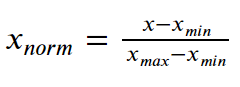

In [249]:
minElement = np.amin(TARGET_CHOSEX)
maxElement = np.amax(TARGET_CHOSEX)

TARGET_CHOSEX = (TARGET_CHOSEX-minElement)/(maxElement - minElement)

In [250]:
minElement = np.amin(SOURCE_CHOSEX)
maxElement = np.amax(SOURCE_CHOSEX)

SOURCE_CHOSEX = (SOURCE_CHOSEX-minElement)/(maxElement - minElement)

**Pada tahapan berikut akan diilakukan penggabungan nilai untuk mendapat nilai mean pada setiap fitur (trdapat 800 dalam kasus ini). sehinga kita kita mendapat nilai mean dengan dataset target dan source ( belum digabung ).**

- note :  tidak diketahui mengapa dibagi 100 

Bugs
Kesalahan dalam penulisan kode untuk mendapat nilai rata2 dari setiap feature

In [251]:
# Matrix Measurements at Caculate Means step
# SOURCE_DATA = np.asarray(pd.read_excel(r'./amazon_result.xlsx'))
# TARGET_DATA = np.asarray(pd.read_excel(r'./lsr_result.xlsx'))

SOURCE_MEAN = []
TARGET_MEAN = []

for i in range(0, len(SOURCE_CHOSEX[0])): 
    sum_a = 0
    for j in range(0, len(SOURCE_CHOSEX)):
        sum_a = sum_a + SOURCE_CHOSEX[j][i]
    res_a = sum_a/len(SOURCE_CHOSEX[j])
    SOURCE_MEAN.append(res_a)

for i in range(0, len(TARGET_CHOSEX[0])): 
    sum_a = 0
    for j in range(0, len(TARGET_CHOSEX)):
        try:
            sum_a = sum_a + TARGET_CHOSEX[j][i]
        except:
            print("An exception occurred")
    res_a = sum_a/len(TARGET_CHOSEX[j])
    TARGET_MEAN.append(res_a)
#calculate for SVHN then 

**Pada tahapan dibawah ini dibuat sebuah model untuk melakukan prediksi. (disini saya tidak akan menjelaskan secara detail untuk masalah algoritma prediksinya).**

In [252]:
#Matrix Measurements Method Call
#maximum mean discrepancy
def mmd(a, b, len_a, len_b):
    return abs(( ((1/len_a)*a) - ((1/len_b)*b) ))

In [253]:
def kernel(params, sv, X):
    return [np.dot(vi, np.transpose(X)) for vi in sv]


def decision_function(params, sv, nv, a, b, X):
    k = kernel(params, sv, X)

    start = [sum(nv[:i]) for i in range(len(nv))]
    end = [start[i] + nv[i] for i in range(len(nv))]

    c = [ sum(a[ i ][p] * k[p] for p in range(start[j], end[j])) +
          sum(a[j-1][p] * k[p] for p in range(start[i], end[i]))
                for i in range(len(nv)) for j in range(i+1,len(nv))]

    return [sum(x) for x in zip(c, b)]

def predict(params, sv, nv, a, b, cs, X):
    decision = decision_function(params, sv, nv, a, b, X)
    votes = [i if decision[p] > 0 else j for p,(i,j) in enumerate(
            (i,j) 
            for i in range(len(cs))
            for j in range(i+1,len(cs))
    )]
# 
    return votes   

# **start learning state 1**

## **learning state 1-1**

**Pada tahapan ini akan dilakukan learning state tahap 1. Pada tahapan ini akan dilakukan perhitungan kesamaan antara mean dari fitur source dan target menggunakan mmd (maximum mean discrepancy). cek fungsi mmd pada code block 9**

**untuk menegtahui lebih jeals bagaimana penggunaan mmd :**
https://www.researchgate.net/figure/Maximum-Mean-Discrepancy-MMD-analysis-of-the-data-population-distributions-a-Diagram_fig2_323558211 

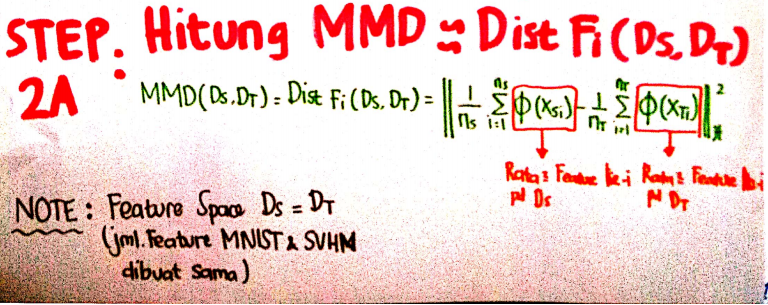

**lalu dibuat mm_mean untuk mengetahui total mean dari semua fitur yang ada.**

In [254]:
#Matrix Measurements at Caculate by Call Method step
MATRIX_MEASURE = []
for i in range(len(SOURCE_MEAN)):
    MATRIX_MEASURE.append((mmd(SOURCE_MEAN[i], TARGET_MEAN[i], len(SOURCE_CHOSEX), len(TARGET_CHOSEX)))**2)

MM_MEAN = np.asarray(MATRIX_MEASURE).mean()

In [255]:
#Data set source akan di cek dengan clasiifer svm dimana setiap bobot nya diambil dari MM_MATRIX sebelum diterapkan policy
clf = svm.LinearSVC(C=1.0, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
# Fit model using features, X, and labels, Y.

METRIC_X= np.dot(SOURCE_CHOSEX, MATRIX_MEASURE)

clf.fit(SOURCE_CHOSEX, SOURCE_CHOSEY,METRIC_X)


PRED_RESULT = clf.predict(TARGET_CHOSEX)

# new data set with pseudo label from previous classification
print("Pseudolabel")
NEW_TARGET_TRAIN_X, NEW_TARGET_TEST_X, NEW_TARGET_TRAIN_Y, NEW_TARGET_TEST_Y = train_test_split(TARGET_CHOSEX, PRED_RESULT, test_size=0.33, random_state=42)

print(NEW_TARGET_TRAIN_X.shape)
print(NEW_TARGET_TRAIN_Y.shape)
print("== Here")

clf.fit(NEW_TARGET_TRAIN_X, NEW_TARGET_TRAIN_Y)

NEW_PRED_RESULT = clf.predict(NEW_TARGET_TEST_X)

matrix = confusion_matrix(NEW_TARGET_TEST_Y, NEW_PRED_RESULT)
print(matrix)
metric_akur = accuracy_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT)
print(metric_akur)
metric_preci = precision_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT, average='weighted')
print(metric_preci)
metric_recal = recall_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT,  average='weighted')
print(metric_recal)
metric_balap = f1_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT, average='weighted')
print(metric_balap)

#no policy
data_excel = [] 
for i in range(len(matrix)):
    data_excel.append([])
    for j in range(len(matrix[0])):
        data_excel[len(data_excel)-1].append(matrix[i][j])
data_excel.append(["Accuracy"]);
data_excel.append([metric_akur]);
data_excel.append(["Precision"]);
data_excel.append([metric_preci]);
data_excel.append(["Recal"]);
data_excel.append([metric_recal]);
data_excel.append(["F1"]);
data_excel.append([metric_balap]);

means_df = pd.DataFrame(data_excel)
means_df.to_excel("matrix_measurement_no_policy_aw.xlsx")

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[28  0  0  0  0  0  0  0  0  0]
 [21  0  0  0  0  0  0  0  0  0]
 [31  0  0  0  0  0  0  0  0  0]
 [23  0  0  4  0  0  0  0  0  0]
 [27  0  0  0  0  0  0  0  0  0]
 [30  0  0  0  0  0  0  0  0  0]
 [42  0  0  1  0  0  0  0  0  0]
 [28  0  0  2  0  0  0  0  0  0]
 [27  0  0  0  0  0  0  0  0  0]
 [30  0  0  0  0  0  0  0  0  0]]
0.10884353741496598
0.0617696555974306
0.10884353741496598
0.038539860388599884


# **start learning state 2**

## **ls2-1**

**akan dilakukan tahap ke 2 yaitu melakukan penentuan fitur (feature selection) pada 800 fitur yang ada. pemilihan dilakukan dengan cara membandingkan fitur dengan nilai total mean matriks. hasil dari fitur yang diambil ada pada choose_feature dan nilai dari fitur tersebut ada di choose_matrix.**

- note : kemungkinan besar nilai fitur yang dipilih 1/2 dari fitur yang ada. bila ingin 0.5 mungkin dilakukan scaling min-max terlebih dahulu sehingga tahu rangenya.

In [256]:
#Choose features by policy
CHOOSE_MATRIX = []
CHOOSE_FEATURE = []

for i in range(len(MATRIX_MEASURE)):
    if(MATRIX_MEASURE[i] <= MM_MEAN and MATRIX_MEASURE[i] != 0):
        CHOOSE_FEATURE.append(i)
        CHOOSE_MATRIX.append(MATRIX_MEASURE[i])

**setelah kita mendapatkan fitur yang mana saja yang akan diambil maka akan dilakukan perhitungan weight dari matriks yang telah dipilih. dengan cara ((1/len(CHOOSE_MATRIX))*MM_TOTAL)/MATRIX_MEASURE[j] . bila nilai dari weight adalah infinite akan dibuah menjadi nilai 0 . isi dari nilai weight matrix adalah nilai semua fitur namun yang tidak dipilih maupun infinite menjadi 0.**

In [257]:
#Calculate Weights
WEIGHT_MATRIX = []
MM_TOTAL = np.sum(np.array(MATRIX_MEASURE))

REAL_WEIGHTMATRIX = []
for j in range(len(MATRIX_MEASURE)):
    if(np.isin(j, CHOOSE_FEATURE)):
        res = ((1/len(CHOOSE_MATRIX))*MM_TOTAL)/MATRIX_MEASURE[j]
        if(np.isfinite(res)):
            WEIGHT_MATRIX.append(res)
            REAL_WEIGHTMATRIX.append(res)
        else:
            WEIGHT_MATRIX.append(sys.maxint)
    else:
        WEIGHT_MATRIX.append(0)

In [258]:
##SVM Classifier Kernel RBF
clf = svm.LinearSVC(C=1.0, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
# Fit model using features, X, and labels, Y.

METRIC_X= np.dot(SOURCE_CHOSEX , WEIGHT_MATRIX)

clf.fit(SOURCE_CHOSEX, SOURCE_CHOSEY,METRIC_X)


PRED_RESULT = clf.predict(TARGET_CHOSEX)

# new data set with pseudo label from previous classification
print("Pseudolabel")
NEW_TARGET_TRAIN_X, NEW_TARGET_TEST_X, NEW_TARGET_TRAIN_Y, NEW_TARGET_TEST_Y = train_test_split(TARGET_CHOSEX, PRED_RESULT, test_size=0.33, random_state=42)

print(NEW_TARGET_TRAIN_X.shape)
print(NEW_TARGET_TRAIN_Y.shape)
print("== Here")

clf.fit(NEW_TARGET_TRAIN_X, NEW_TARGET_TRAIN_Y)

NEW_PRED_RESULT = clf.predict(NEW_TARGET_TEST_X)

matrix = confusion_matrix(NEW_TARGET_TEST_Y, NEW_PRED_RESULT)
print(matrix)
metric_akur = accuracy_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT)
print(metric_akur)
metric_preci = precision_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT, average='weighted')
print(metric_preci)
metric_recal = recall_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT,  average='weighted')
print(metric_recal)
metric_balap = f1_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT, average='weighted')
print(metric_balap)

#no policy
data_excel = [] 
for i in range(len(matrix)):
    data_excel.append([])
    for j in range(len(matrix[0])):
        data_excel[len(data_excel)-1].append(matrix[i][j])
data_excel.append(["Accuracy"]);
data_excel.append([metric_akur]);
data_excel.append(["Precision"]);
data_excel.append([metric_preci]);
data_excel.append(["Recal"]);
data_excel.append([metric_recal]);
data_excel.append(["F1"]);
data_excel.append([metric_balap]);

means_df = pd.DataFrame(data_excel)
means_df.to_excel("matrix_measurement_policy_aw.xlsx")

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[20  2  0  2  0  2  1  0  1  0]
 [ 4 13  1  0  0  0  0  0  3  0]
 [ 2  0 18  2  4  1  2  0  2  0]
 [ 5  2  0 19  0  0  1  0  0  0]
 [ 0  0  7  1  8  9  2  0  0  0]
 [ 2  0  2  2  0  4 14  2  2  2]
 [ 6  0  2  4  0  5 18  0  0  8]
 [ 5  0  0  8  2  1  2  7  2  3]
 [ 3  0  1  1  0  6  2  7  2  5]
 [ 3  0  1  5  0  9  5  1  0  6]]
0.391156462585034
0.3940416850107854
0.391156462585034
0.37613308815646135


In [259]:
#Choose features by policy
CHOOSE_MATRIX = []
CHOOSE_FEATURE = []

for i in range(len(MATRIX_MEASURE)):
    if(MATRIX_MEASURE[i] <= MM_MEAN and MATRIX_MEASURE[i] != 0):
        CHOOSE_FEATURE.append(i)
        CHOOSE_MATRIX.append(MATRIX_MEASURE[i])

In [260]:
#Calculate Weights
WEIGHT_MATRIX = []
MM_TOTAL = np.sum(np.array(MATRIX_MEASURE))

REAL_WEIGHTMATRIX = []
for j in range(len(MATRIX_MEASURE)):
    if(np.isin(j, CHOOSE_FEATURE)):
        res = 1
        WEIGHT_MATRIX.append(res)
        REAL_WEIGHTMATRIX.append(res)
    else:
        WEIGHT_MATRIX.append(0)

In [261]:

clf = svm.LinearSVC(C=1.0, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
# Fit model using features, X, and labels, Y.

METRIC_X= np.dot(SOURCE_CHOSEX , WEIGHT_MATRIX)

clf.fit(SOURCE_CHOSEX, SOURCE_CHOSEY,METRIC_X)


PRED_RESULT = clf.predict(TARGET_CHOSEX)

# new data set with pseudo label from previous classification
print("Pseudolabel")
NEW_TARGET_TRAIN_X, NEW_TARGET_TEST_X, NEW_TARGET_TRAIN_Y, NEW_TARGET_TEST_Y = train_test_split(TARGET_CHOSEX, PRED_RESULT, test_size=0.33, random_state=42)

print(NEW_TARGET_TRAIN_X.shape)
print(NEW_TARGET_TRAIN_Y.shape)
print("== Here")

clf.fit(NEW_TARGET_TRAIN_X, NEW_TARGET_TRAIN_Y)

NEW_PRED_RESULT = clf.predict(NEW_TARGET_TEST_X)

matrix = confusion_matrix(NEW_TARGET_TEST_Y, NEW_PRED_RESULT)
print(matrix)
metric_akur = accuracy_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT)
print(metric_akur)
metric_preci = precision_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT, average='weighted')
print(metric_preci)
metric_recal = recall_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT,  average='weighted')
print(metric_recal)
metric_balap = f1_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT, average='weighted')
print(metric_balap)

#no policy
data_excel = [] 
for i in range(len(matrix)):
    data_excel.append([])
    for j in range(len(matrix[0])):
        data_excel[len(data_excel)-1].append(matrix[i][j])
data_excel.append(["Accuracy"]);
data_excel.append([metric_akur]);
data_excel.append(["Precision"]);
data_excel.append([metric_preci]);
data_excel.append(["Recal"]);
data_excel.append([metric_recal]);
data_excel.append(["F1"]);
data_excel.append([metric_balap]);

means_df = pd.DataFrame(data_excel)
means_df.to_excel("matrix_measurement_policy_aw.xlsx")

/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[23  1  0  2  0  0  1  0  1  0]
 [ 2 18  0  0  0  0  0  0  1  0]
 [ 2  0 21  3  2  1  1  0  1  0]
 [ 4  2  0 20  0  0  1  0  0  0]
 [ 0  0  9  1  7  8  1  0  0  1]
 [ 4  1  0  4  0  3 11  4  1  2]
 [ 3  0  0  7  0  4 21  1  0  7]
 [ 5  0  0  8  0  0  3  8  2  4]
 [ 3  0  1  1  0  6  3  5  2  6]
 [ 4  0  1  3  0  6  5  2  0  9]]
0.4489795918367347
0.45208630219184426
0.4489795918367347
0.42340061375931376


# **start learning state 3**

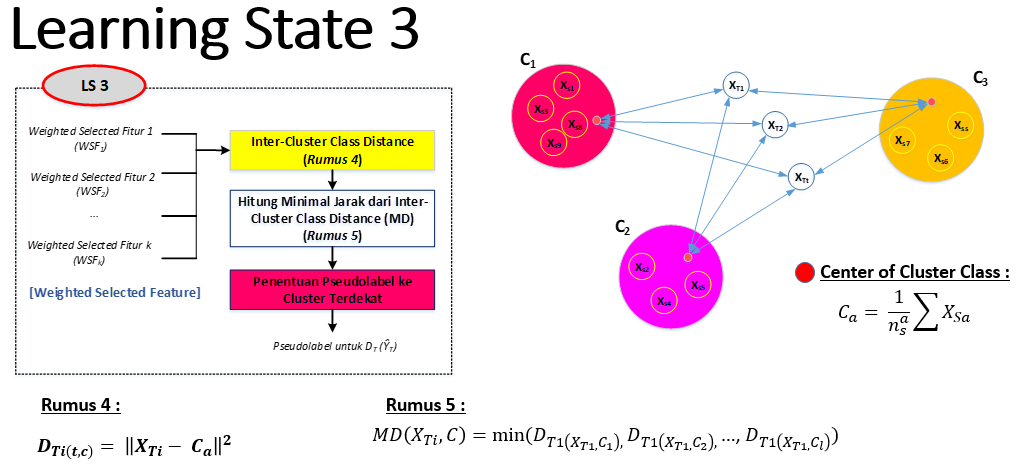

## **Penggunaan rumus center of cluster class**

**pada tahapan ini akan dilakukan pencarain nilai mean pada setiap gambar yang ada pada data source dan target ( disini semua fitur dipakai)**

In [262]:
#Get mean of every instances on MNIST
SOURCE_DATA_EACH_MEAN = []

for i in range(0, len(SOURCE_CHOSEX)):
    SOURCE_DATA_EACH_MEAN.append(np.mean(np.array(SOURCE_CHOSEX[i])))
    
#Get mean of every instances on SVHN
TARGET_DATA_EACH_MEAN = []

for i in range(0, len(TARGET_CHOSEX)):
    TARGET_DATA_EACH_MEAN.append(np.mean(np.array(TARGET_CHOSEX[i])))

**pada tahapan ini dimulai pencarian center dari data source dengan menjumlahkan semua mean yang ada dan membaginya.** (1/SOURCE_CLUSTSIZE[i]) * SOURCE_CENTRE["%s"%i] 

In [263]:
# SOURCE Cluster
SOURCE_CENTRE = {}
SOURCE_CLUSTSIZE = []
for i in range (0, 10):
    SOURCE_CENTRE["%s"%i] = 0
    
# SOURCE_X, SOURCE_Y
for i in range (0, 10):
    SOURCE_CLUSTSIZE.append(0)
    for j in range(0, len(SOURCE_CHOSEX)):
        if(SOURCE_CHOSEY[j] == i):
            SOURCE_CLUSTSIZE[i] = SOURCE_CLUSTSIZE[i]+1
            SOURCE_CENTRE["%s"%i]= SOURCE_CENTRE["%s"%i] + np.mean(SOURCE_CHOSEX[j])

for i in range(0, len(SOURCE_CENTRE)):
    # ditambahan dikarenakan ada hasil clustersize yang 0
    if SOURCE_CLUSTSIZE[i] == 0 :
      SOURCE_CLUSTSIZE[i] = 1
    # -------------------------------------------------
    SOURCE_CENTRE["%s"%i] = (1/SOURCE_CLUSTSIZE[i]) * SOURCE_CENTRE["%s"%i]
            
SOURCE_CENTRE


{'0': 0.0,
 '1': 0.020530772190986403,
 '2': 0.01965288900074612,
 '3': 0.019892134022522177,
 '4': 0.0210620920050674,
 '5': 0.01889578247353586,
 '6': 0.019932236736206994,
 '7': 0.02020465511413255,
 '8': 0.02012112350006437,
 '9': 0.02029261527102522}

Disini telah dihapus target cluster pada code sebelumnya dikarenakan pada pengguanan real data target tidak memeliki label :

(ketuk 2 kali untuk melihat code yang tidak dipakai)
<!-- TARGET_CENTRE = {} 
for i in range (0, 10):
    TARGET_CENTRE["%s"%i] = 0

index  = 0
for i in range (0, len(TARGET_PROCESS)):
    TARGET_CENTRE["%s"%index]= TARGET_CENTRE["%s"%index] + np.mean(TARGET_PROCESS[i])
    if(i % 800 == 0 and i != 0):
        index = index+1

print(TARGET_CENTRE)
for i in range(0, len(TARGET_CENTRE)):
    TARGET_CENTRE["%s"%i] = (1/800) * TARGET_CENTRE["%s"%i]

print("Hasilnya")
print(TARGET_CENTRE) -->


## **Learning State 3-1**

### **Penggunaan rumus 4**

**dilakukan pencarian distance dari data source dan target ke center masing masing pencarian ini digunakan untuk mengetahui nilai terkecil dari source data mean awal ke center terdekat berapa jaraknya.**

In [264]:
#Calculate distances from SOURCE data to cluster
SOURCE_DIST = []

for i in range(0, len( SOURCE_DATA_EACH_MEAN)):
    SMALLEST = 10000000
    SOURCE_DIST.append(SMALLEST)
    for j in range(0, len(SOURCE_CENTRE)):
        SOURCE_ADIST = np.absolute(SOURCE_DATA_EACH_MEAN[i] - SOURCE_CENTRE["%s"%j])
        if(SOURCE_ADIST < SMALLEST):  
            SOURCE_DIST[i] = SOURCE_ADIST
            SMALLEST = SOURCE_ADIST
SOURCE_DIST

[1.7472718242587948e-05,
 3.2033134597389545e-05,
 7.208582250026185e-05,
 0.00024472401802009755,
 0.00021016445794199562,
 0.00011499241590397918,
 0.00025325631055193865,
 3.272179420941296e-05,
 9.676313003031262e-05,
 0.0001569465503948493,
 4.561654423286196e-05,
 0.00030001995638832477,
 0.00034567621521684744,
 1.1968304078281006e-05,
 0.0002007532188398782,
 4.716542935552515e-06,
 0.0002539528141760339,
 0.0003464550248058716,
 0.0003377953583432701,
 9.571263152726231e-05,
 0.0005232789791168452,
 0.00020822440881787183,
 5.850849629204097e-05,
 0.0003271138204312164,
 3.150118520877515e-06,
 0.00014157839830938532,
 6.871597716620603e-05,
 2.174437375183219e-05,
 2.816403276010085e-05,
 0.0009156441417178703,
 6.985585890394858e-05,
 0.0008721827303874129,
 2.3442390034537908e-06,
 0.0013816803351761504,
 2.6391416991511374e-06,
 0.0015993500099863896,
 0.00024751844003988166,
 0.00039243957494318124,
 0.000752156541477058,
 0.00014384284130972147,
 6.387069703148174e-05,
 

**setelah nilai terpendek sudah didapt tinggal dikali dengan nilai bobot fitur yang telah terpilih sehingga mengahasilkan nilai seperti dibawah. (masih dalam bentuk terpisah source dan taget belum melebur).**

In [265]:
#Calculate distances from TARGET data to cluster (source cluster)
TARGET_DIST = []

for i in range(0, len( TARGET_DATA_EACH_MEAN)):
    SMALLEST = 10000000
    TARGET_DIST.append(SMALLEST)
    for j in range(0, len(SOURCE_CENTRE)):
        TARGET_ADIST = np.absolute(TARGET_DATA_EACH_MEAN[i] - SOURCE_CENTRE["%s"%j])
        if(TARGET_ADIST < SMALLEST):  
            TARGET_DIST[i] = TARGET_ADIST
            SMALLEST = TARGET_ADIST
TARGET_DIST

[0.017606364622551832,
 0.016047337813387002,
 0.01779003173545379,
 0.01681432718699331,
 0.016546274463364635,
 0.018933832110758646,
 0.01884592732097323,
 0.017170859554958732,
 0.019011942834499976,
 0.020142575115933908,
 0.0182462278372116,
 0.017639868981335478,
 0.017562336223048914,
 0.017085205143394063,
 0.02013111618690488,
 0.018613672727514425,
 0.01818098421714059,
 0.023293698763825737,
 0.021934087813938154,
 0.02093175895193612,
 0.020743040317429937,
 0.02152368902560871,
 0.020536769707412115,
 0.02068864284651929,
 0.023263513280004065,
 0.022651677032665154,
 0.022160847929680306,
 0.02101324948866379,
 0.02365767154595028,
 0.023895450077948566,
 0.02241578565883769,
 0.024216571831777587,
 0.02499038929471496,
 0.023964360190456373,
 0.024212537494329275,
 0.02374898604050515,
 0.022218352470673493,
 0.025578895497817698,
 0.02329708266662368,
 0.02285315804475008,
 0.02491652671099395,
 0.022417130823766184,
 0.022225898553056563,
 0.023760830053926586,
 0.024

real weight dan hanya dikali oleh distance

In [266]:
#Total Value for SOURCE
SOURCE_TV = []

for i in range(0, len(SOURCE_DIST)):
    FEATURE_TIME = 1
    for j in range(0, len(REAL_WEIGHTMATRIX)):
        FEATURE_TIME *= REAL_WEIGHTMATRIX[j]
    SOURCE_TV.append(SOURCE_DIST[i] * FEATURE_TIME)
SOURCE_TV

[1.7472718242587948e-05,
 3.2033134597389545e-05,
 7.208582250026185e-05,
 0.00024472401802009755,
 0.00021016445794199562,
 0.00011499241590397918,
 0.00025325631055193865,
 3.272179420941296e-05,
 9.676313003031262e-05,
 0.0001569465503948493,
 4.561654423286196e-05,
 0.00030001995638832477,
 0.00034567621521684744,
 1.1968304078281006e-05,
 0.0002007532188398782,
 4.716542935552515e-06,
 0.0002539528141760339,
 0.0003464550248058716,
 0.0003377953583432701,
 9.571263152726231e-05,
 0.0005232789791168452,
 0.00020822440881787183,
 5.850849629204097e-05,
 0.0003271138204312164,
 3.150118520877515e-06,
 0.00014157839830938532,
 6.871597716620603e-05,
 2.174437375183219e-05,
 2.816403276010085e-05,
 0.0009156441417178703,
 6.985585890394858e-05,
 0.0008721827303874129,
 2.3442390034537908e-06,
 0.0013816803351761504,
 2.6391416991511374e-06,
 0.0015993500099863896,
 0.00024751844003988166,
 0.00039243957494318124,
 0.000752156541477058,
 0.00014384284130972147,
 6.387069703148174e-05,
 

In [267]:
#Total Value for TARGET
TARGET_TV = []

for i in range(0, len(TARGET_DIST)):
    FEATURE_TIME = 1
    for j in range(0, len(REAL_WEIGHTMATRIX)):
        FEATURE_TIME *= REAL_WEIGHTMATRIX[j]
    TARGET_TV.append(TARGET_DIST[i] * FEATURE_TIME)
TARGET_TV

[0.017606364622551832,
 0.016047337813387002,
 0.01779003173545379,
 0.01681432718699331,
 0.016546274463364635,
 0.018933832110758646,
 0.01884592732097323,
 0.017170859554958732,
 0.019011942834499976,
 0.020142575115933908,
 0.0182462278372116,
 0.017639868981335478,
 0.017562336223048914,
 0.017085205143394063,
 0.02013111618690488,
 0.018613672727514425,
 0.01818098421714059,
 0.023293698763825737,
 0.021934087813938154,
 0.02093175895193612,
 0.020743040317429937,
 0.02152368902560871,
 0.020536769707412115,
 0.02068864284651929,
 0.023263513280004065,
 0.022651677032665154,
 0.022160847929680306,
 0.02101324948866379,
 0.02365767154595028,
 0.023895450077948566,
 0.02241578565883769,
 0.024216571831777587,
 0.02499038929471496,
 0.023964360190456373,
 0.024212537494329275,
 0.02374898604050515,
 0.022218352470673493,
 0.025578895497817698,
 0.02329708266662368,
 0.02285315804475008,
 0.02491652671099395,
 0.022417130823766184,
 0.022225898553056563,
 0.023760830053926586,
 0.024

### **Penggunaan rumus 5**

pada tahapan ini baru dilakukan perhitungan jarak antara souce to target dimana ditentukan gap nilai dari source ke target. nilai gap tersebut akan disimpan pada gap_source_to_target. lalu didapat prediksi dari target y dengan melihat nili terkecil

In [268]:
#predicts TARGET Label Belongings
TARGET_PRED = []

for i in range(0, len(TARGET_TV)):
    GAP_SOURCE_TO_TARGET = []
    for j in range(0, len(SOURCE_TV)):
        GAP_SOURCE_TO_TARGET.append(np.absolute(SOURCE_TV[j]- TARGET_TV[i]))
    TARGET_PRED.append(SOURCE_CHOSEY[np.argmin(GAP_SOURCE_TO_TARGET)])
    
TARGET_PRED

[array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),
 array([8]),

# **test prediction**

In [269]:

clf = svm.LinearSVC(C=1.0, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
# Fit model using features, X, and labels, Y

clf.fit(SOURCE_CHOSEX, SOURCE_CHOSEY, GAP_SOURCE_TO_TARGET)

PRED_RESULT = clf.predict(TARGET_CHOSEX)

# new data set with pseudo label from previous classification
print("Pseudolabel")
NEW_TARGET_TRAIN_X, NEW_TARGET_TEST_X, NEW_TARGET_TRAIN_Y, NEW_TARGET_TEST_Y = train_test_split(TARGET_CHOSEX, PRED_RESULT, test_size=0.33, random_state=42)

print(NEW_TARGET_TRAIN_X.shape)
print(NEW_TARGET_TRAIN_Y.shape)
print("== Here")

clf.fit(NEW_TARGET_TRAIN_X, NEW_TARGET_TRAIN_Y)

NEW_PRED_RESULT = clf.predict(NEW_TARGET_TEST_X)

matrix = confusion_matrix(NEW_TARGET_TEST_Y, NEW_PRED_RESULT)
print(matrix)
metric_akur = accuracy_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT)
print(metric_akur)
metric_preci = precision_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT, average='weighted')
print(metric_preci)
metric_recal = recall_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT,  average='weighted')
print(metric_recal)
metric_balap = f1_score(NEW_TARGET_TEST_Y, NEW_PRED_RESULT, average='weighted')
print(metric_balap)

#no policy
data_excel = [] 
for i in range(len(matrix)):
    data_excel.append([])
    for j in range(len(matrix[0])):
        data_excel[len(data_excel)-1].append(matrix[i][j])
data_excel.append(["Accuracy"]);
data_excel.append([metric_akur]);
data_excel.append(["Precision"]);
data_excel.append([metric_preci]);
data_excel.append(["Recal"]);
data_excel.append([metric_recal]);
data_excel.append(["F1"]);
data_excel.append([metric_balap]);

means_df = pd.DataFrame(data_excel)
means_df.to_excel("matrix_measurement_until_finish_aw.xlsx")



# means_df = pd.DataFrame(confusion_matrix(MNIST_CHOSEY, SVHN_PRED))
# means_df.to_excel("measurements_metrics.xlsx")


/home/gitpod/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[28  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0]
 [ 2  4 19  1  1  3  1  0  0  0]
 [ 0  4  0 23  0  0  0  0  0  0]
 [ 3  0 12  1  1 10  0  0  0  0]
 [ 4  1  0  6  0  0 16  2  0  1]
 [ 9  0  0 11  0  1 21  0  0  1]
 [ 7  1  0 12  0  1  3  5  1  0]
 [11  0  1  0  0  8  3  1  0  3]
 [11  0  0  9  0  2  5  1  0  2]]
0.40816326530612246
0.3745210860842032
0.40816326530612246
0.3303105673962647
